# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
D = np.loadtxt('../data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

In [2]:
import matplotlib.pyplot as plt

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
X = np.hstack((X,np.ones((X.shape[0],1))))
y = np.array(Y).reshape(-1,1)

In [72]:
class LinearRegression:
    def __init__(self):

        self.W = None
    def init_weights(self, input_size, output_size):

        self.W = np.random.normal(0, 0.01, (input_size, output_size))

    def predict(self, X):

        return  X @ self.W
    
    def evaluate (self, X, y, alpha):
        n = len(y)
        preds = self.predict(X)
        return np.sum((preds-y)**2)/n + (float(sum(self.W**2)/n))*alpha #MSE
    
    #с градиентным спуском
    def fit(self, X, y, X_test=None,y_test=None,num_epochs=100, lr=0.001, alpha = 0.1):
        n = len(y)     
        loss_f = lambda preds, y, alpha: np.sum((preds-y)**2)/n + (float(sum(self.W**2)/n))*alpha #MSE+рег
        self.init_weights(X.shape[1], y.shape[1])
        loss = []
        if type(X_test) is np.ndarray and type(y_test) is np.ndarray:
            val_loss = []
        for epoch in range(num_epochs):
            preds = self.predict(X)
            W_grad = 2*X.T@(preds - y)/n + alpha*self.W
            self.W -= lr*W_grad
            error = loss_f(preds, y, alpha)
            loss.append(error)
            if type(X_test) is np.ndarray and type(y_test) is np.ndarray:
                val_loss.append(self.evaluate(X_test,y_test,alpha))
        if type(X_test) is not np.ndarray or type(y_test) is not np.ndarray: 
            return loss
        else:
            return loss, val_loss
    

    #явный метод
    def solve(self, X, y, alpha):
        n = len(y)
        loss_f = lambda preds, y, alpha: np.sum((preds-y)**2)/n + (float(sum(self.W**2)/n))*alpha
        W = np.linalg.inv(X.T @ X + alpha * np.identity(5)) @ X.T @ y
        preds = X @ W      
        error = loss_f(preds, y, alpha)
        return error


In [73]:
lin_regressor = LinearRegression()

In [74]:
alpha_grid = np.arange(0.001,5,0.01)
list_epoch_loss = []
for alpha in alpha_grid:
    list_epoch_loss.append(lin_regressor.fit(X,y,alpha=alpha)[-1])

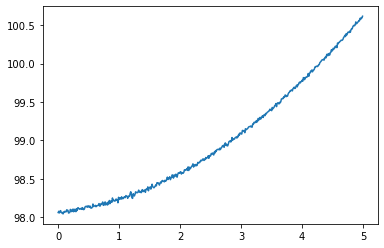

In [75]:
plt.plot(alpha_grid,list_epoch_loss)

In [78]:
from numpy.random import permutation
dataset = np.hstack((X,y))
dataset = permutation(dataset)
X_new = dataset[:,:-1]
y_new = dataset[:,-1].reshape(-1,1)

In [79]:
k = 5
#функция для генерации тестовой и обучающей выборки
def K_fold_cv(k,X,y):
    n = len(y)
    for i in range(k):
        yield X[n*i//k:n*(i+1)//k], y[n*i//k:n*(i+1)//k], \
                np.delete(X,np.s_[n*i//k:n*(i+1)//k],axis = 0), \
                np.delete(y,np.s_[n*i//k:n*(i+1)//k],axis = 0)

In [80]:
alphas_loss = []
new_alpha_grid = np.arange(0.001,5,0.1)
for alpha in new_alpha_grid:
    generator = K_fold_cv(k,X_new,y_new)
    cv_loss = []
    for i in range (k):
        X_test, y_test, X_train, y_train = next(generator)
        lin_regressor.fit(X_train,y_train, alpha=alpha)
        cv_loss.append(lin_regressor.evaluate(X_test,y_test,alpha))
    alphas_loss.append(np.mean(cv_loss))

In [82]:
print(np.min(alphas_loss))
optim_alpha = alpha_grid[np.argmin(alphas_loss)]
print ('alpha = ',optim_alpha)

98.50672477685586
alpha =  0.001


In [83]:
X_test, y_test, X_train, y_train = next(K_fold_cv(k,X_new,y_new))
train_loss, val_loss = lin_regressor.fit(X_train,y_train,X_test=X_test,y_test=y_test,alpha=optim_alpha)

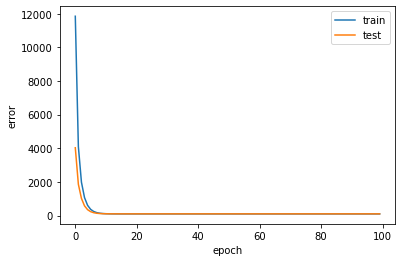

In [84]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label = 'test')

plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show()